# MADDPG - Collaboration and Competition
---

This notebook is a walkthrough of the third assignment of the [Udacity Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893), which consists on solving the [Tennis](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Learning-Environment-Examples.md#tennis) environment.

<img src="https://video.udacity-data.com/topher/2018/May/5af7955a_tennis/tennis.png" alt-text="Tennis Environment" height="10"></img>

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1. If an agent let's a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01. Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Each agent receives its own, local observation. Two continuous actions are available, correponding to movement toward (or away from) the net, and jumping.

The task is episodic, and in order to solve the environment, the agents must get an average score of +0.5 (over 100 consecutive episodes, after taking the maximum of both agents). Specifically,

* After each episode, we add up the rewards that each agent received (without discounting), to get a score for each agent. This yields 2 (potentially different) scores. Then the maximum score of these 2 agent is taken.
* This yields a **single** score for each episode.

In [1]:
!pip -q install ../python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 2.0.10 which is incompatible.


In [11]:
from collections import deque
import numpy as np
import torch

import sys
sys.path.append('ddpg-collaboration')

from models.actor import Actor
from models.critic import Critic
from agent import Agent
from utils.utils import plot_result

from unityagents import UnityEnvironment
import matplotlib.pyplot as plt
from workspace_utils import active_session

%matplotlib inline

Loading the environment

In [4]:
path = '/data/Tennis_Linux_NoVis/Tennis'

env = UnityEnvironment(file_name=path)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Getting the `brain_name`, a **brain** is responsible for deciding the actions of their associated agents. 

In [5]:
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

## Checking the State and Action spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1. If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01. Thus, the goal is to keep the ball in play.

The observation space consists of 24 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping.

In [6]:
env_info = env.reset(train_mode=True)[brain_name]

num_agents = len(env_info.agents)
print(f'Number of agents: {num_agents}')

action_size = brain.vector_action_space_size
print(f'Size of each action: {action_size}')

states = env_info.vector_observations
state_size = states.shape[1]
print(f'There are {num_agents} agents. Each observes a state with length: {state_size}')
print(f'The state for the first agent looks like: {states[0]}')

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


## Random Actions

Taking random actions to check how the environment behaves.

In [ ]:
for i in range(1, 6):
    env_info = env.reset(train_mode=False)[brain_name]
    states = env_info.vector_observations
    scores = np.zeros(num_agents)
    
    while True:
        actions = np.random.randn(num_agents, action_size)
        actions = np.clip(actions, -1, 1)
        env_info = env.step(actions)[brain_name]
        next_states = env_info.vector_observations
        rewards = env_info.rewards
        dones = env_info.local_done
        
        scores += env_info.rewards
        states = next_states
        
        if np.any(dones):
            break
            
    print(f'Score (max over agents) from episode {i}: {np.max(scores)}')

In [ ]:
env.close()

## Solving the Environment -- MADDPG

This environment will be solved using MADDPG, which is the multi-agent version of the DDPG algorithm. DDPG is an algorithm based on [Deep Q-Networks](https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf) to work on continous problems. It works with two networks: an actor and a critic. The actor is responsible for, given a state, perform an action (deterministic algorithm, choosing a single action, and not probabilities over the possible actions as DQN), while the critic will predict a score for this action on the state (judging how good was the action performed by the actor). 

Like DQNs, DDPG also works with Experience Replay, where it stores a bunch of `(state, action, rewards, next_state, done)` tuples and then sample it randomly for training (removing the correlation between state-action tuples). 

Also like DQNs, the DDPG has a `target` network for the actor and the critic, responsible for predicting the targets on the training stage. The weights of the local networks (the ones being trained) are used to *soft update* the weights of the `target` network, it means, after each iteration, a the weights of the networks are "*mixed*" together based on a parameter τ (which is much less than 1, I've used 0.002). The resulting weights of the `target` network are composed of τ times the weights of the `local` plus (1 - τ) times the current weights of the `target`. This technique has been proved to help stability during learning, ahd improves the result of the algorithm (it could also be used on the DQN arquitecture).

Deep reinforcement learning algorithms are successful because of a duality of exploration and exploitation. On the beginning of the training, the agent does not know much about the environment, and to help it explore the environment correctly, it is usual to add some randomness to the action-choosing process. On the DQN paper, this was implementeed based on a ε-greedy technique, where the agent could choose both the best known action or a random one (on the beginning of the training, the agent would usually choose random actions, and as training develops, the agent gets more *trustyworthy* and starts to choose the best known action). Since the DDPG does not work with probabilities over actions, it cannot make use of ε-greedy for exploration, and to address this problem it's often used to add some noise on the actions on the beginning of training, on this work I've used the Orsntein-Uhlenbeck noise process. The noise added to the action keeps getting smaller as the number of episodes get bigger, and later on training the agent is always choosing the predicted action (without any noise). 

In [7]:
agent = Agent(state_size, action_size, 25, [400, 300], [400, 300])
n_episodes = 5000
max_t = 3000
print_every = 100
train = True

eps_start = 1.5
eps_decay = 0.999
eps_min = 0.01

In [12]:
scores_deque = deque(maxlen=100)
all_scores = []

eps = eps_start

print('Start training session...\n')

with active_session():
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=train)[brain_name]
        states = env_info.vector_observations
        agent.reset()
        scores = np.zeros(num_agents)
        for t in range(1, max_t+1):
            actions = agent.act(states, add_noise=train, epsilon=eps)
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done
            scores += env_info.rewards

            if train:
                agent.step(states, actions, rewards, next_states, dones, t)
            states = next_states

            if np.any(dones):
                break
        eps = max(eps_min, eps * eps_decay)
        scores_deque.append(np.max(scores))
        all_scores.append(scores)

        if i_episode % print_every == 0 or np.mean(scores_deque) >= 0.5:
            print(f'Episode {i_episode}: {np.mean(scores_deque):.4f}')
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.actor_local.state_dict(), 'checkpoint_critic.pth')

            if np.mean(scores_deque) >= 0.5:
                print(f'Environment solved in episode {i_episode}')
                break

Start training session...

Episode 100: 0.0048
Episode 200: 0.0155
Episode 300: 0.0054
Episode 400: 0.0433
Episode 500: 0.1038
Episode 600: 0.1158
Episode 700: 0.1289
Episode 800: 0.1756
Episode 900: 0.2693
Episode 941: 0.5204
Environment solved in episode 941


After using a start epsilon of 1.5 to amplify the noise created by Orsntein-Uhlenbeck noise process on the beginning of training (to help exploration), the agent solved the environment on 941 episodes.

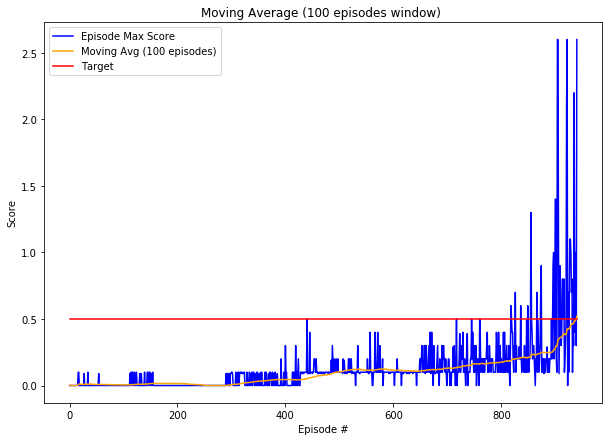

In [18]:
plot_result(all_scores)